# 1. Configuración Inicial

In [29]:
# Instalación de paquetes necesarios
!pip install optuna torchvision folium --quiet


## 1.1 Importación de librerías y versiones
- Librerías
- Comprobación de versiones

In [27]:
# Librerías
import os
import pandas as pd
from google.colab import drive
import cv2
import folium
import folium.plugins as plugins
import matplotlib.pyplot as plt
import numpy as np
import random
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils
from tensorboard import program
from torch.utils.data import DataLoader, Dataset, random_split

In [12]:
# Comprobación de versiones
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Optuna version: {optuna.__version__}")

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
NumPy version: 2.0.2
Pandas version: 2.2.2
Optuna version: 4.3.0


## 1.2 Fijado de semilla y reproducibilidad
- Semilla

In [13]:
# Semilla
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)


## 1.3 Montaje de Google Drive y carga de datos
- Montar Google Drive
- Definir la ruta base a la carpeta del proyecto
- Construir la ruta al archivo de datos usando os.path.join
- Cargar los datos

In [57]:
# Montar Google Drive
drive.mount('/content/drive')

# Definir la ruta base a la carpeta del proyecto
BASE_PATH = '/content/drive/MyDrive/ProyectoDL'

# Construir la ruta al archivo de datos usando os.path.join
data_path = os.path.join(BASE_PATH, 'data', 'poi_dataset.csv')

# Cargar los datos
try:
    df = pd.read_csv(data_path)
    print("¡Archivo cargado exitosamente!")
    print(f"Ruta del archivo: {data_path}")
    print(df.head())

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo en la ruta '{data_path}'")
    print("Por favor, verifica que la ruta y el nombre del archivo son correctos.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
¡Archivo cargado exitosamente!
Ruta del archivo: /content/drive/MyDrive/ProyectoDL/data/poi_dataset.csv
                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería Fran Reus es un espacio dedicado a ...   
1  El Convento de San Plácido en Madrid, fundado ...   
2  

# 2. Análisis Exploratorio de Datos (EDA)


## 2.1 Descripción general del dataset

- Primeras filas de los datos
- Información general y tipos de datos
- Dimensiones del dataset


In [58]:
# Primeras filas de los datos
df.head()

,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
0,4b36a3ed-3b28-4bc7-b975-1d48b586db03,Galería Fran Reus,La Galería Fran Reus es un espacio dedicado a ...,"['Escultura', 'Pintura']",1,2.642262,39.572694,[],500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1,e32b3603-a94f-49df-8b31-92445a86377c,Convento de San Plácido,"El Convento de San Plácido en Madrid, fundado ...","['Patrimonio', 'Historia']",1,-3.704467,40.423037,[],500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2,0123a69b-13ac-4b65-a5d5-71a95560cff5,Instituto Geológico y Minero de España,"El Instituto Geológico y Minero de España, sit...","['Ciencia', 'Patrimonio']",2,-3.699694,40.442045,[],250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3,390d7d9e-e972-451c-b5e4-f494af15e788,Margarita Gil Roësset,"Margarita Gil Roësset, escultora y poetisa esp...",['Cultura'],1,-3.691228,40.427256,[],500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4,023fc1bf-a1cd-4b9f-af78-48792ab1a294,Museo del Traje. Centro de Investigación del P...,"El Museo del Traje de Madrid, fundado en 2004,...","['Patrimonio', 'Cultura']",1,-3.727822,40.439665,[],500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...


In [59]:
# Información general del dataset
print("\nInformación del dataset:")
df.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1569 non-null   object 
 1   name              1569 non-null   object 
 2   shortDescription  1569 non-null   object 
 3   categories        1569 non-null   object 
 4   tier              1569 non-null   int64  
 5   locationLon       1569 non-null   float64
 6   locationLat       1569 non-null   float64
 7   tags              1569 non-null   object 
 8   xps               1569 non-null   int64  
 9   Visits            1569 non-null   int64  
 10  Likes             1569 non-null   int64  
 11  Dislikes          1569 non-null   int64  
 12  Bookmarks         1569 non-null   int64  
 13  main_image_path   1569 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 171.7+ KB


In [60]:
# Dimensiones (filas, columnas)
print("\nDimensión Dataset:")
df.shape


Dimensión Dataset:


(1569, 14)

## 2.2 Valores nulos

- Conteo de valores nulos por columna

In [61]:
# Conteo de valores nulos por columna
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
id                  0
name                0
shortDescription    0
categories          0
tier                0
locationLon         0
locationLat         0
tags                0
xps                 0
Visits              0
Likes               0
Dislikes            0
Bookmarks           0
main_image_path     0
dtype: int64


## 2.3 Análisis de variables numéricas

Principales variables numéricas:

- Visits
- Likes
- Dislikes
- Bookmarks
- tier
- xps


In [62]:
# Estadísticas descriptivas
df[["Visits", "Likes", "Dislikes", "Bookmarks", "tier", "xps"]].describe().round()

,Visits,Likes,Dislikes,Bookmarks,tier,xps
count,1569.0,1569.0,1569.0,1569.0,1569.0,1569.0
mean,10012.0,3624.0,2526.0,973.0,2.0,750.0
std,5.0,4818.0,2226.0,1453.0,1.0,228.0
min,10001.0,100.0,52.0,50.0,1.0,0.0
25%,10008.0,464.0,937.0,116.0,1.0,600.0
50%,10011.0,1434.0,2718.0,306.0,1.0,700.0
75%,10015.0,6840.0,3399.0,1309.0,2.0,1000.0
max,10038.0,26425.0,10999.0,8157.0,4.0,1000.0


- **Visits** tiene una media y mediana muy próximas, pero un rango muy estrecho (min=10001, max=10038), lo que indica poca variabilidad en el número de visitas entre los POIs.
- **Likes**, **Dislikes** y **Bookmarks** presentan rangos mucho más amplios y distribuciones asimétricas (la media es mucho mayor que la mediana), lo que indica posible presencia de outliers o asimetría positiva.
- **tier** varía entre 1 y 4, siendo 1 el valor más frecuente (mediana=1).
- **xps** varía entre 0 y 1000, con percentiles altos bastante agrupados en torno al máximo.

**Conclusión:**  
Las variables `Likes`, `Dislikes` y `Bookmarks` pueden necesitar un tratamiento especial de outliers o al menos una exploración visual para entender su dispersión.  
La variable `Visits` tiene muy poca variabilidad, por lo que puede aportar poco poder predictivo.

## 2.4 Análisis de variables categóricas

Variables categóricas:

- tier
  - Valores únicos encontrados.
  - Frecuencia.


- categories
  - Número total de categorías únicas detectadas.
  - Top 10 categorías más frecuentes.

- tags
  - Número total de tags únicos.
  - Top 10 tags más frecuentes.



In [63]:
# Análisis de la variable 'tier'
print("Valores únicos en 'tier':", df["tier"].unique())
print("Frecuencia de 'tier':")
print(df["tier"].value_counts())
print("\n")

Valores únicos en 'tier': [1 2 3 4]
Frecuencia de 'tier':
tier
1    837
2    622
3    103
4      7
Name: count, dtype: int64




In [47]:
# Variable 'categories'
all_categories = [cat for cats in df["categories"].apply(eval) for cat in cats]
unique_categories = set(all_categories)
cat_frequencies = pd.Series(all_categories).value_counts()
print("Valores únicos de 'categories':")
print(df["categories"].unique()[:5])
print("Número total de categorías únicas:", len(cat_frequencies))
print("Top 10 categorías más frecuentes:")
print(cat_frequencies.head(10))
print("\n")

Valores únicos de 'categories':
["['Escultura', 'Pintura']" "['Patrimonio', 'Historia']"
 "['Ciencia', 'Patrimonio']" "['Cultura']" "['Patrimonio', 'Cultura']"]
Número total de categorías únicas: 12
Top 10 categorías más frecuentes:
Historia        1297
Cultura         1030
Arquitectura     660
Patrimonio       603
Escultura        482
Misterio         382
Ciencia          132
Ocio              76
Pintura           48
Naturaleza        43
Name: count, dtype: int64




In [48]:
# Análisis de la variable 'tags'
all_tags = [tag for tags in df["tags"].apply(eval) for tag in tags]
tag_frequencies = pd.Series(all_tags).value_counts()

print("\nValores únicos de 'tags' en la muestra:")
print(df["tags"].unique()[:5])
print("Número total de tags únicos:", len(tag_frequencies))
print("Top 10 tags más frecuentes:")
print(tag_frequencies.head(10))


Valores únicos de 'tags' en la muestra:
['[]' "['s.XX']"
 "['Canaletto', 'paisaje', 'vedutismo', 's.XVIII', 'Cuadro', 'Venecia']"
 "['s.XX', 'Primera Guerra Mundial ', 'expresionismo', 'paisaje', 'Cuadro']"
 "['Cuadro', 's.XX']"]
Número total de tags únicos: 2935
Top 10 tags más frecuentes:
Historia        802
Madrid          700
Cultura         583
Arquitectura    398
Patrimonio      353
Arte            329
Escultura       328
Estatua         269
Monumento       166
Naturaleza      150
Name: count, dtype: int64


## 2.5 Visualización geoespacial de los POIs

- Mapa interactivo con la ubicación de todos los POIs y popup informativo.

In [49]:
# Mapa centrado en la media de las coordenadas
center_lat = df['locationLat'].mean()
center_lon = df['locationLon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Añadir marcadores para cada POI
for idx, row in df.iterrows():
    # Creación de el popup con información relevante
    popup_text = f"""
    <b>{row['name']}</b><br>
    Tier: {row['tier']}<br>
    Categories: {', '.join(eval(row['categories']))}<br>
    Visits: {row['Visits']}<br>
    Likes: {row['Likes']}<br>
    """
    # Marcador
    folium.Marker(
        location=[row['locationLat'], row['locationLon']],
        popup=popup_text,
        icon=folium.Icon(color='red' if row['tier'] == 1 else 'blue')
    ).add_to(m)

# Control de capas y minimapa
folium.LayerControl().add_to(m)
plugins.MiniMap().add_to(m)

#Mostrar mapa
m

## 2.6 Visualización exploratoria de imágenes

- Grid de imágenes aleatorias de POIs con su nivel de tier.


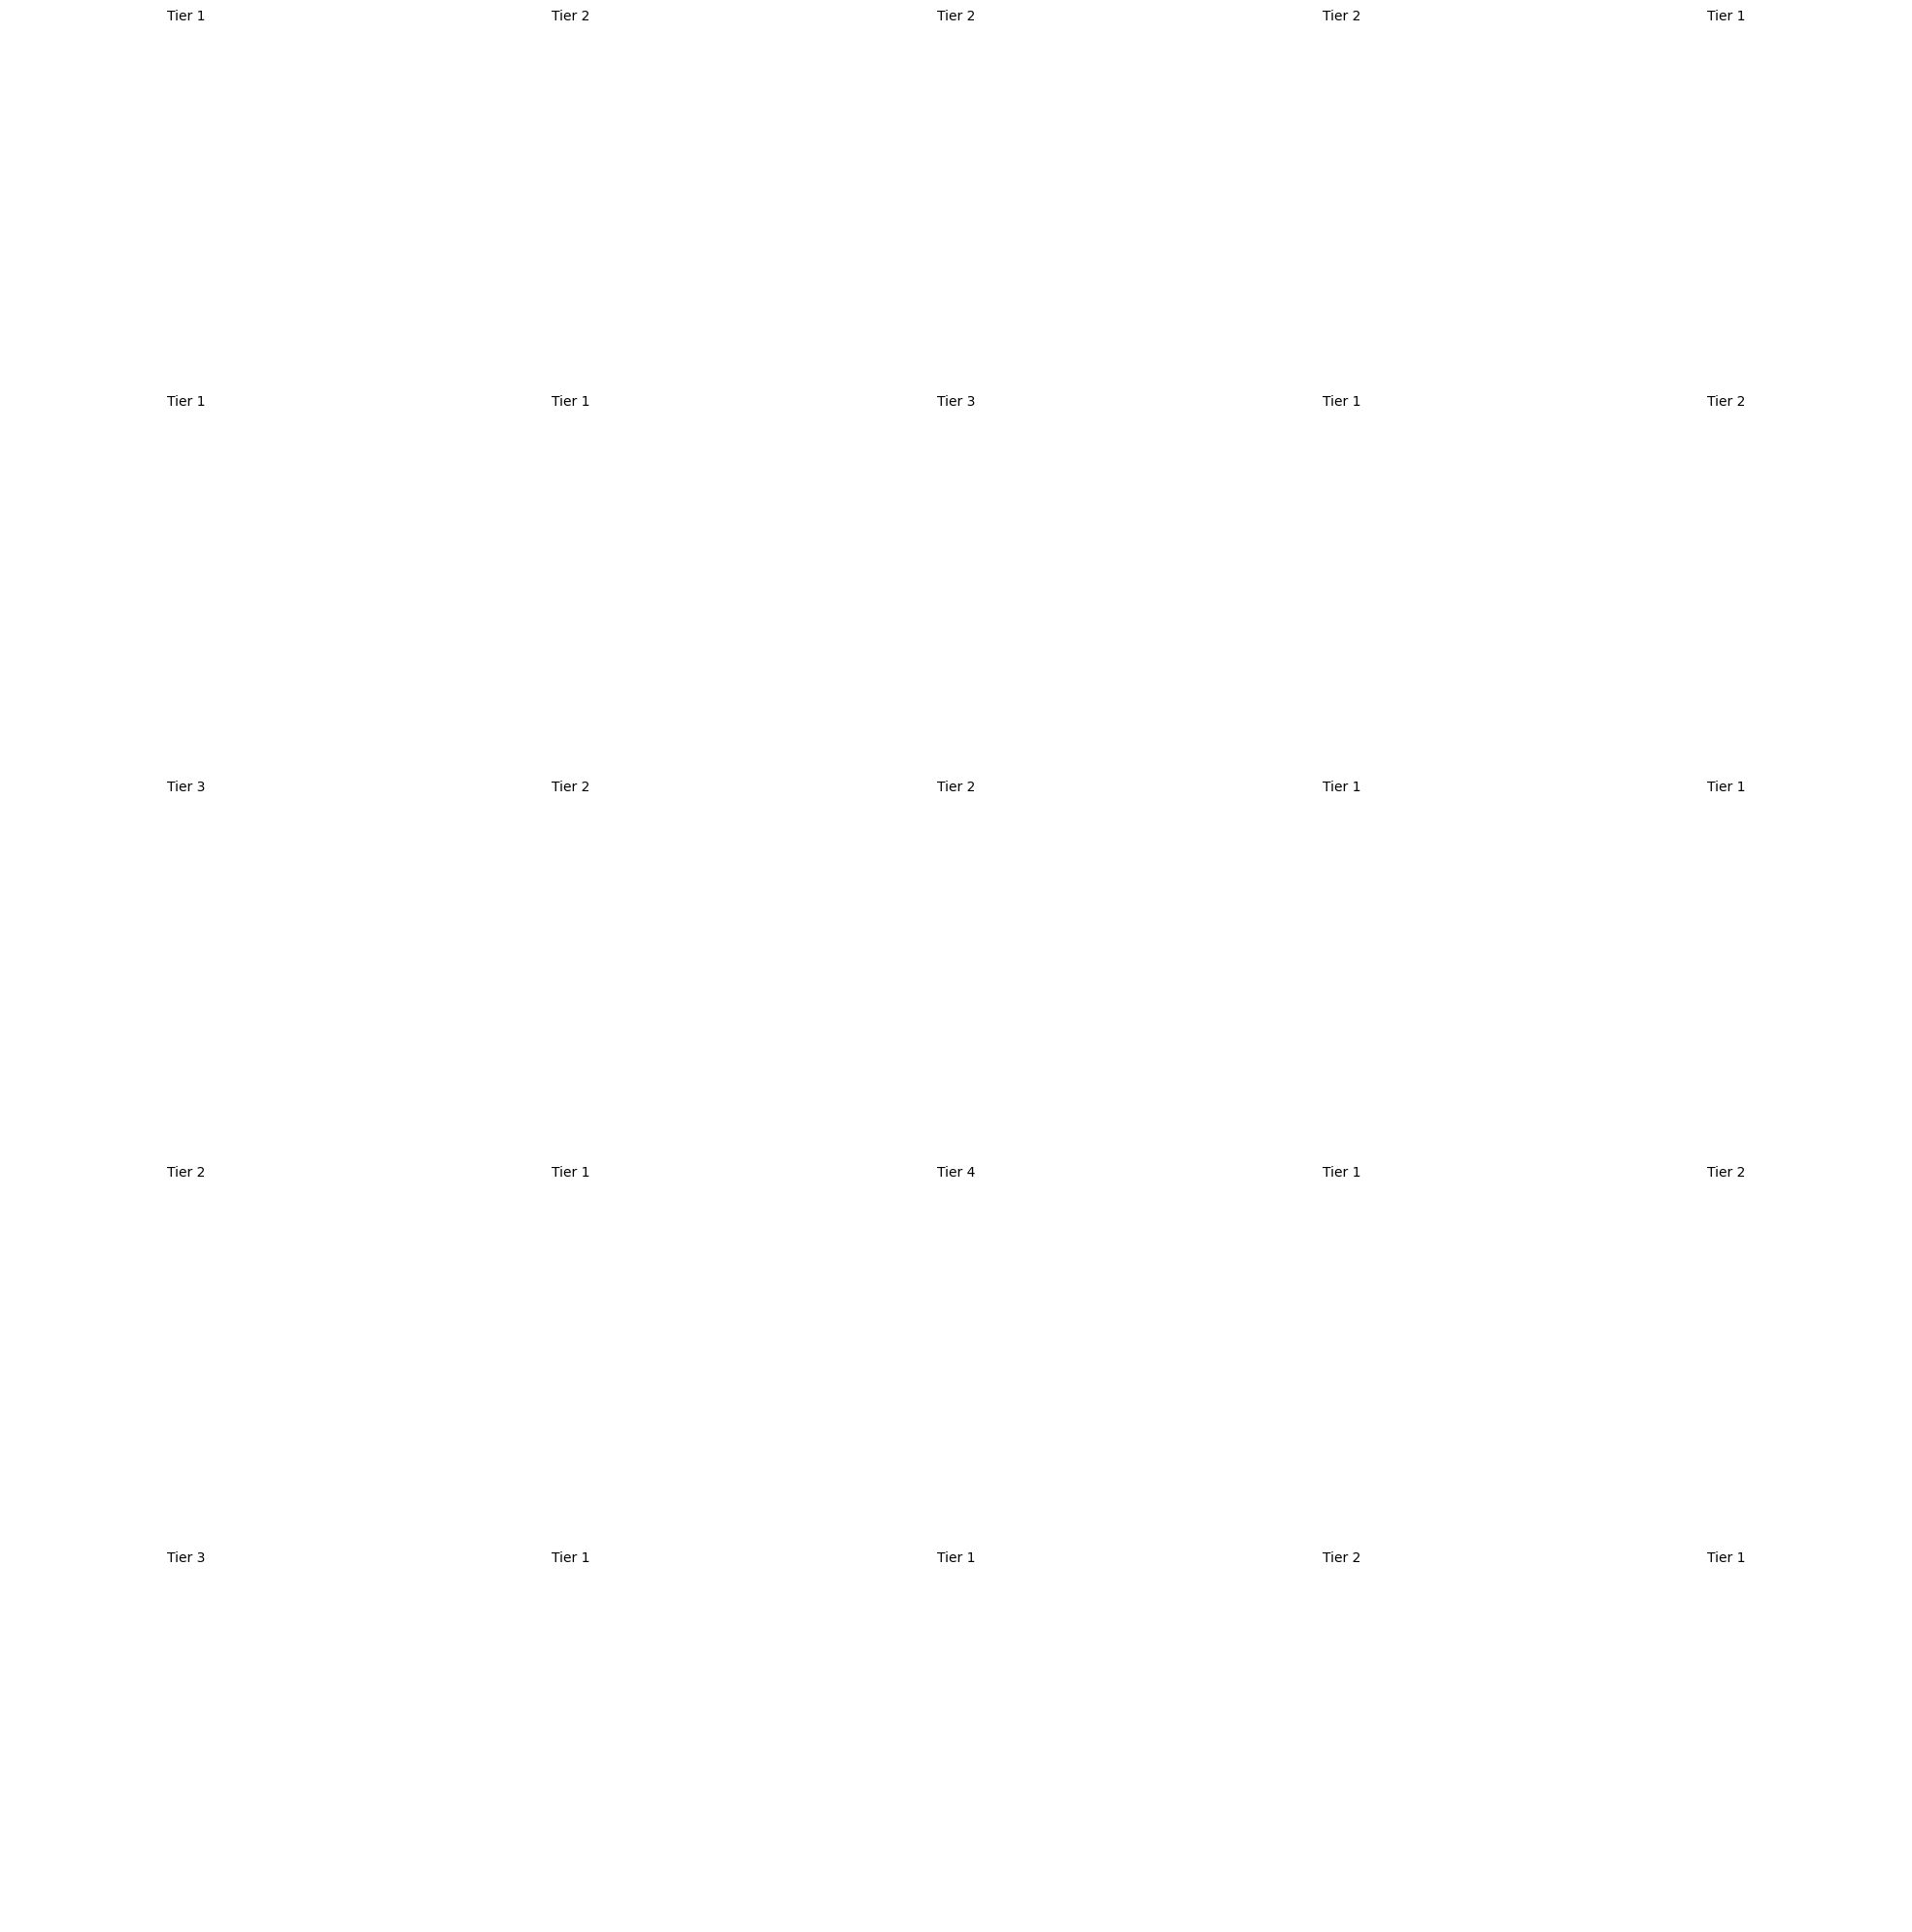

In [56]:
# Selecciona 25 imágenes aleatorias
sample_images = df.sample(n=25, random_state=42)

plt.figure(figsize=(20, 20))
for idx, (_, row) in enumerate(sample_images.iterrows()):
    # Construye la ruta completa a la imagen
    img_path = os.path.join(BASE_PATH, row['main_image_path'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # Si la imagen no existe, muestra un cuadro blanco
        img = np.ones((224, 224, 3), dtype=np.uint8) * 255
    plt.subplot(5, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Tier {row['tier']}", fontsize=10)
plt.tight_layout()
plt.show()


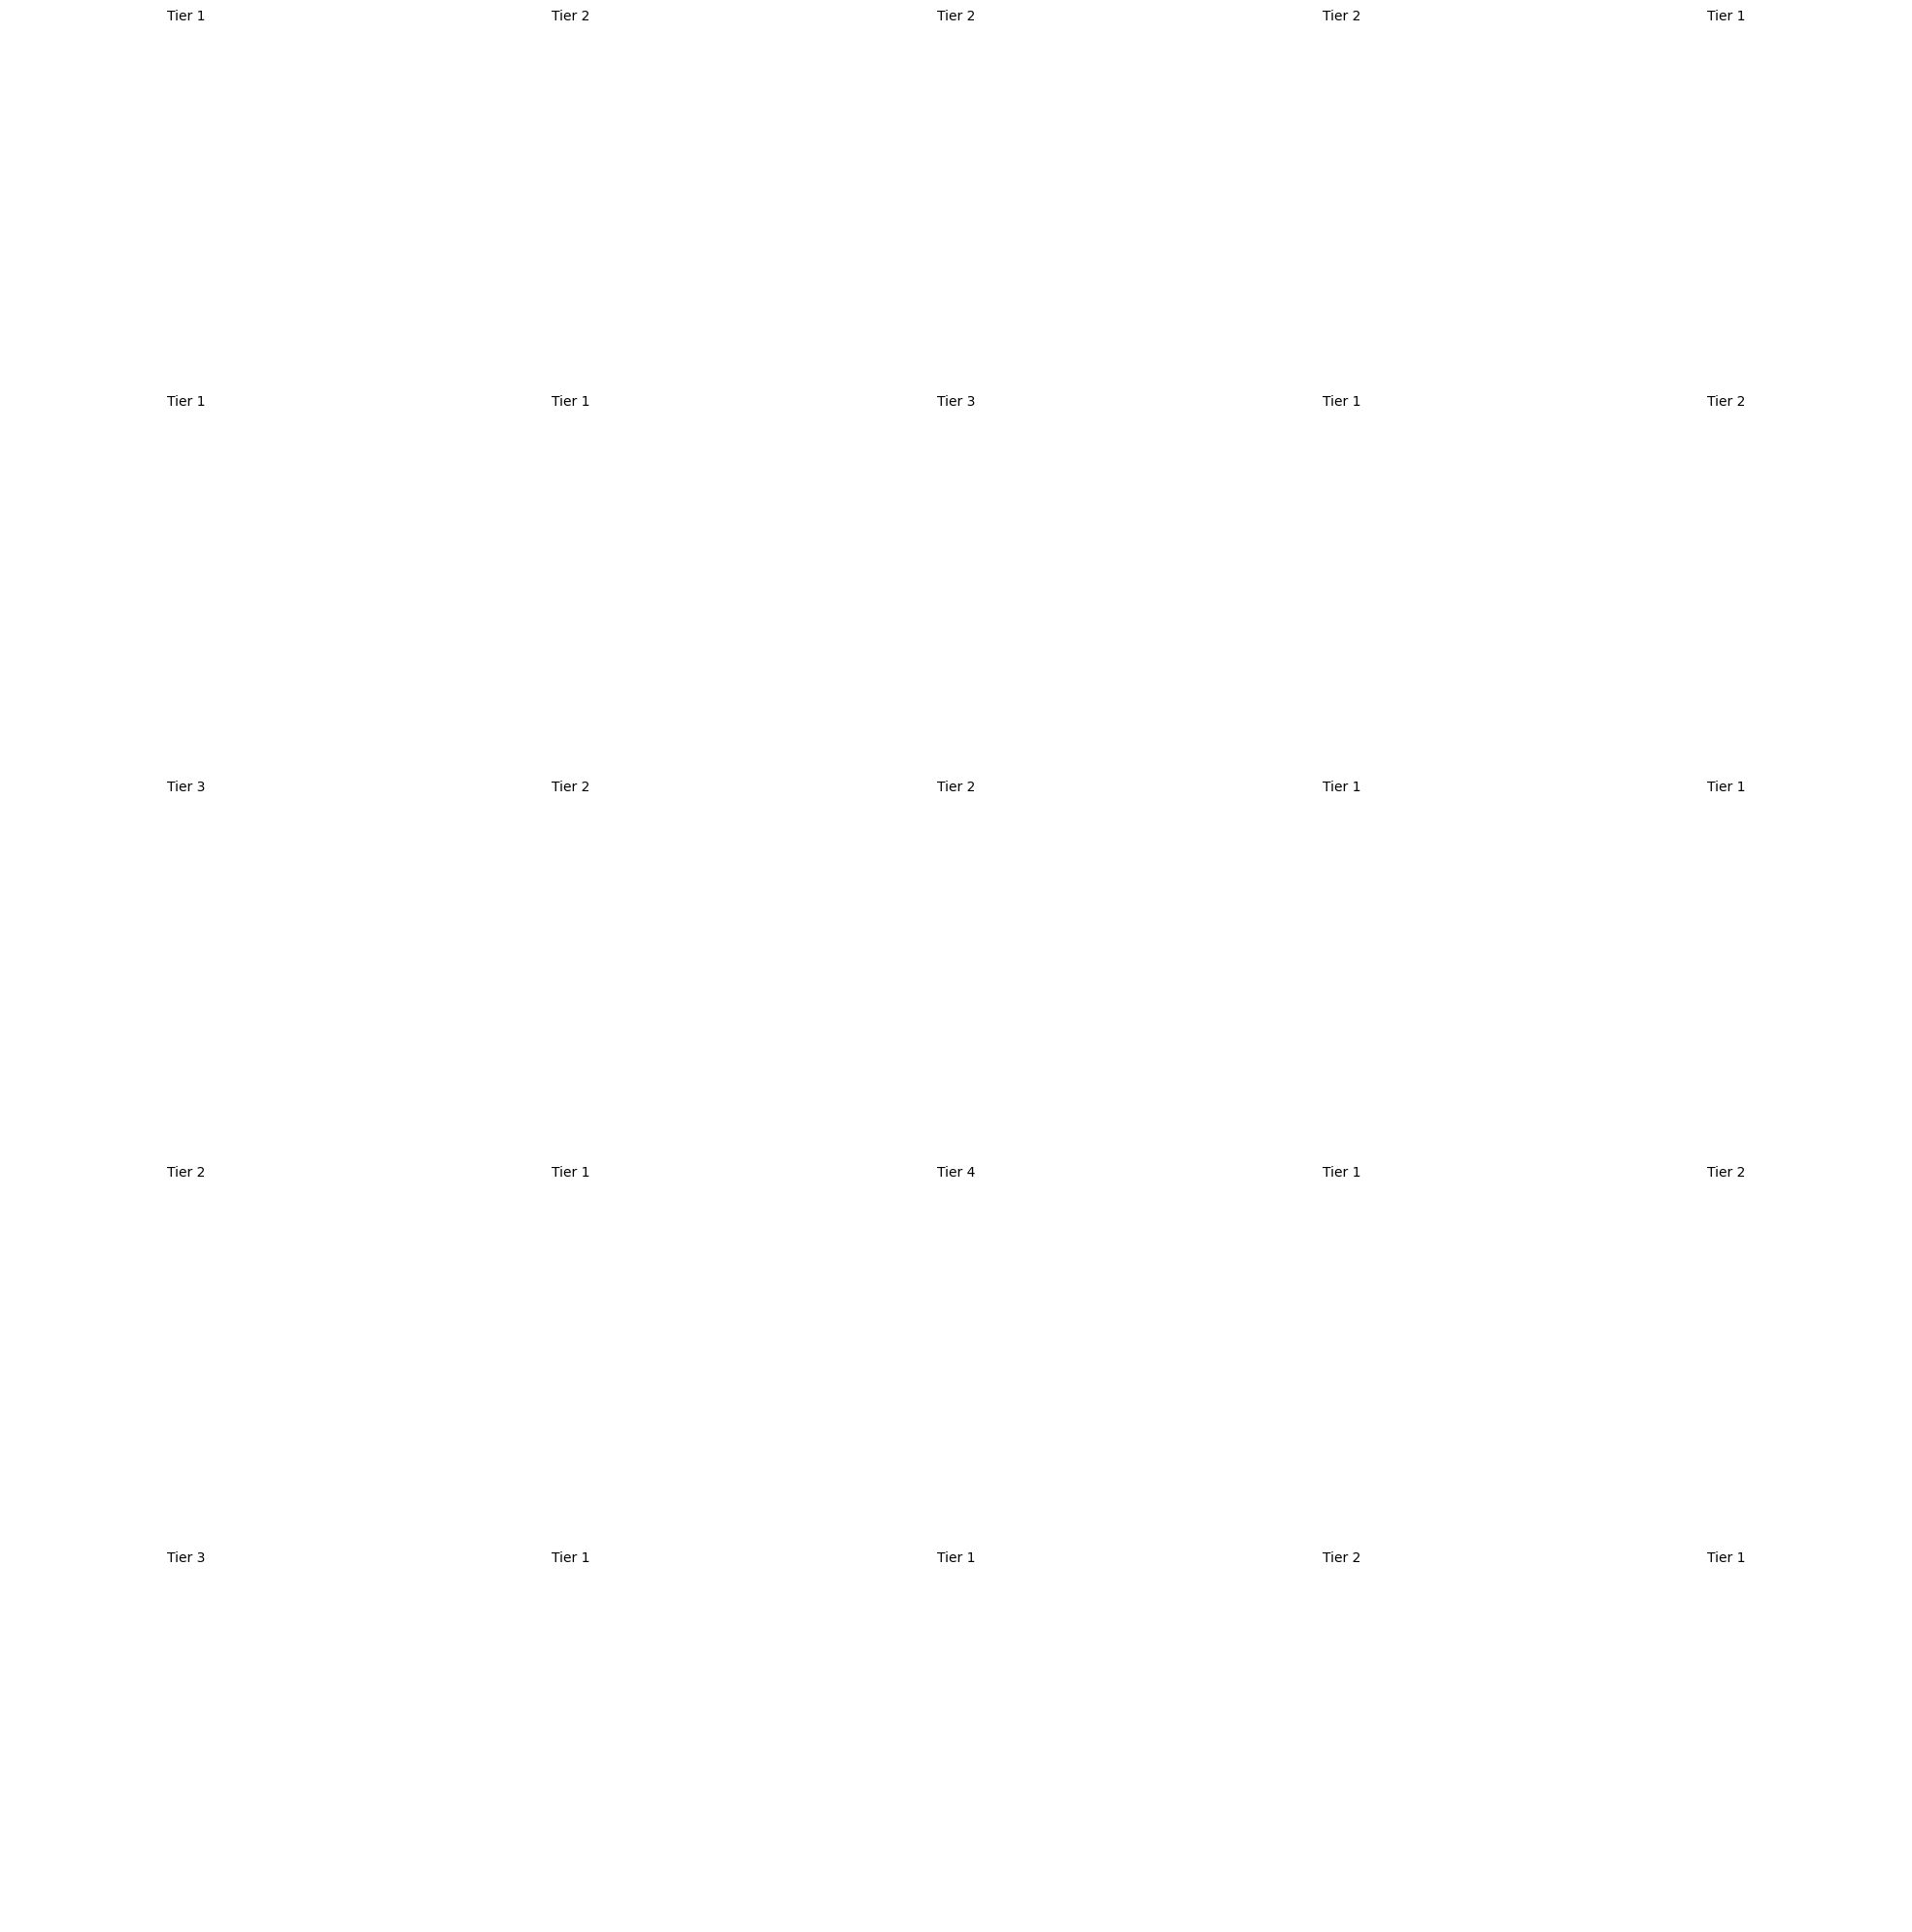

In [54]:
# Selección de 25 imágenes aleatorias
sample_images = df.sample(n=25, random_state=42)

plt.figure(figsize=(20,20))
for idx, (_, row) in enumerate(sample_images.iterrows()):
    img = cv2.imread(row['full_image_path'])
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # Si la imagen no existe, crea un cuadro blanco
        import numpy as np
        img = np.ones((224, 224, 3), dtype=np.uint8) * 255
    plt.subplot(5, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Tier {row['tier']}", fontsize=10)
plt.tight_layout()
plt.show()


In [55]:
# Mostrar rutas y comprobar existencia de las primeras 10 imágenes aleatorias
for _, row in sample_images.iterrows():
    print(row['full_image_path'], os.path.exists(row['full_image_path']))


/content/drive/MyDrive/ProyectoDL/data_main/data_main/6a2e353d-6799-4c6e-9351-5d3af0c5bd8c/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/a1f96973-0a8a-46bf-931f-7d6c0bb291b5/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/ff864690-aa3d-4cb8-bbf6-090265070be4/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/aad14446-f958-48cf-a6ef-166810c2a1f9/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/a0145cf5-cc85-47c6-a4c8-1e91e4452acc/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/2c2f71b5-585f-49b3-9907-f061817fd77c/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/0bb262c6-24d2-4ba7-8ca5-75769aa8ba09/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/7b3869ca-2771-4c83-bf26-36494e9943ca/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/data_main/941f523d-3bd7-4157-a8c3-ba51786c3a33/main.jpg False
/content/drive/MyDrive/ProyectoDL/data_main/da

# Ejemplo profesor

1.1 Visualización del mapa

Para las features geoespaciales (latitud y longitud) podemos realizar varios procesamientos:

Normalización: Escalar las coordenadas a un rango [-1,1] o [0,1] para que tengan la misma escala que otras features y facilitar el entrenamiento.

Cálculo de distancias:
○ Distancia al centro de la ciudad/región
○ Distancia entre POIs
○ Densidad de POIs en un radio determinado

Clustering geográfico:
○ K-means sobre coordenadas para identificar zonas
○ DBSCAN para encontrar clusters de densidad
○ Asignar etiquetas de zona/barrio

Transformaciones:
○ Conversión a coordenadas cartesianas (x,y,z)
○ Cálculo de bearing/orientación
○ Discretización en cuadrículas/hexágonos

Transformaciones:
○ Conversión a coordenadas cartesianas (x,y,z)
○ Cálculo de bearing/orientación
○ Discretización en cuadrículas/hexágonos

Features contextuales:
○ Proximidad a puntos de interés conocidos
○ Indicadores de centralidad/periferia
○ Densidad poblacional de la zona

No es necesario hacer todo esto, pero vamos a mostrar el mapa de los POIs para ver dónde están los POIs.

Para la solución del problema no es necesario procesar los datos geográficos ni hacer análisis espaciales, ya que el objetivo principal es clasificar las imágenes según su nivel de engagement. Sin embargo, procesar esta información y extraer características como:

• Distancia al centro de la ciudad
• Densidad de POIs en la zona
• Indicadores de centralidad/periferia Podría aportar valor añadido al modelo y demostrar ingenio en el aprovechamiento de todos los datos disponibles.

Por simplicidad y para centrarnos en el objetivo principal, no realizaremos este análisis espacial en esta solución.

In [ ]:
# Analizamos la calidad de las imágenes calculando el contraste y nitidez
image_quality_metrics = []

for _, row in df.iterrows():
    # Leemos la imagen
    img = cv2.imread(f"{row['main_image_path']}")
    # Convertimos a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculamos el contraste (desviación estándar)
    contrast = np.std(gray)

    # Calculamos la nitidez usando el Laplaciano
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    sharpness = np.var(laplacian)

    # Combinamos las métricas en un score
    quality_score = (contrast + sharpness) / 2
    image_quality_metrics.append(quality_score)

# Creamos el histograma
plt.figure(figsize=(10, 6))
plt.hist(image_quality_metrics, bins=50, edgecolor='black')
plt.title('Distribución de la Calidad de las Imágenes')
plt.xlabel('Score de Calidad')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

# Mostramos algunas estadísticas
print(f"Calidad media: {np.mean(image_quality_metrics):.2f}")
print(f"Calidad mediana: {np.median(image_quality_metrics):.2f}")


In [ ]:
# Creamos una figura con subplots
plt.figure(figsize=(20, 12))

# Para cada nivel de engagement
for j, (level, description) in enumerate(zip(engagement_levels, engagement_descriptions)):
    # Encontramos lugares con engagement score cercano al nivel deseado
    closest_places = df.iloc[(df['engagement_score_normalized'] - level).abs().argsort()[:images_per_level]]
    # Mostramos las imágenes para este nivel
    for i in range(images_per_level):
        plt.subplot(len(engagement_levels), images_per_level, i + images_per_level * j + 1)
        # Leemos y mostramos la imagen
        img = plt.imread(f"{closest_places.iloc[i]_


In [ ]:
# Calculamos la correlación entre el engagement score y la calidad de la imagen
df['image_quality_score'] = image_quality_metrics

# Creamos un scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['image_quality_score'], df['engagement_score_normalized'])
plt.title('Correlación entre Calidad de Imagen y Engagement')
plt.xlabel('Score de Calidad de Imagen')
plt.ylabel('Score de Engagement Normalizado')
plt.show()
